# Sentiment analysis in Pytorch 1: using a simple RNN

In [1]:
# all imports
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.optim as optim
from plots.plots import plot_confusion_matrix, plot_histogram_from_labels
from text_processing.functions import simple_pre_process_text_df, simple_pre_process_text
from text_generation.sentiment import generate_sentiment_data
% matplotlib inline

Creating the data

In [2]:
generate_sentiment_data()

Index(['text', 'labels'], dtype='object')
Index(['text', 'labels'], dtype='object')


Speak about the dataset [First GOP debate twitter sentiment](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment)

In [3]:
train_data_path = 'data/sentiment_train.csv'
test_data_path = 'data/sentiment_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
train_data.head()

,text,labels
0,Airton é paciente,1
1,Nina é tanto sossegada quanto insincera,2
2,"Taís é humanitária, mas as vezes ele parece se...",1
3,Brandão é genuíno,1
4,Olívia nunca foi neurótica,2


In [5]:
test_data.head()

,text,labels
0,Anabela nunca foi obcecada,2
1,"Mariana é esplêndida, mas as vezes ele parece ...",1
2,Jader é preparado,1
3,Madate é determinado,1
4,Catarina nunca foi intransigente,2


In [6]:
labels_legend = ['Negative','Positive', 'Neutral']
sentiment2int = {'Negative':0, 'Positive':1, 'Neutral':2}
int2sentiment = {i[1]: i[0] for i in sentiment2int.items()}
train_labels = train_data["labels"].values
test_labels =  test_data["labels"].values

Plotting the data histogram

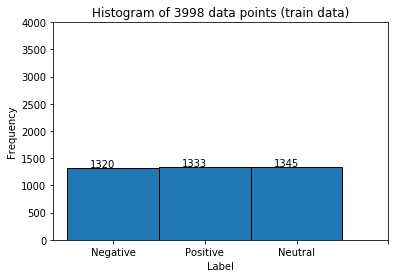

In [7]:
plot_histogram_from_labels(train_labels, labels_legend, "train data")

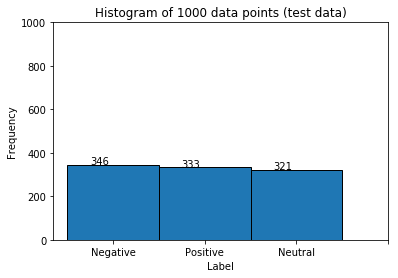

In [8]:
plot_histogram_from_labels(test_labels, labels_legend, "test data")

Vizualizating some tweets

In [9]:
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])

Taís é humanitária, mas as vezes ele parece ser instável

Brandão é genuíno

Olívia nunca foi neurótica


In [10]:
print("\nAFTER using the function simple_pre_process_text_df \n")
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


AFTER using the function simple_pre_process_text_df 

tas humanitria mas as vezes ele parece ser instvel

brando genuno

olvia nunca foi neurtica


Now we can save the preprocessed text as a csv

In [11]:
# train_data = train_data[["text", "sentiment"]]
# test_data = test_data[["text", "sentiment"]]
# train_data.to_csv('data/gop_tweets/train_clean.csv', header=False, index=False)
# test_data.to_csv('data/gop_tweets/test_clean.csv', header=False, index=False)

We use the`data.Field` to hold all the text data:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

and the class `data.LabelField` to hold the labels:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.

In [12]:
# TEXT = data.Field(tokenize='spacy')
# LABEL = data.LabelField(tensor_type=torch.FloatTensor)

And so we can create a dataset by using the class `data.TabularDataset` and the data in the `csv` format

In [13]:
# train = data.TabularDataset(path='data/gop_tweets/train_clean.csv',
#                             format="csv",
#                             fields=[('text', TEXT), ('label', LABEL)])

# test = data.TabularDataset(path='data/gop_tweets/test_clean.csv',
#                             format="csv",
#                             fields=[('text', TEXT), ('label', LABEL)])

Creating the train-valid split (80$\%$ for training data and 20$\%$ for validation data)

In [14]:
# train, valid = train.split(0.8)

In [15]:
# print('len(train):', len(train))
# print('len(valid):', len(valid))
# print('len(test):', len(test))

Constructing the Vocabulary, using at maximun 25000 words

In [16]:
# TEXT.build_vocab(train, max_size=25000)
# LABEL.build_vocab(train)

In [17]:
# print('len(TEXT.vocab):', len(TEXT.vocab))
# print('len(LABEL.vocab):', len(LABEL.vocab))

Printing the 20 most frequent words

In [18]:
# print(TEXT.vocab.freqs.most_common(20))

- `.itos` is the `int2str` method from the object `TEXT.vocab` 
- `.stoi` is the `str2int` method from the object `TEXT.vocab` 

In [19]:
# print("TEXT.vocab.itos")
# print("word", "index")

# for i, word in enumerate(TEXT.vocab.itos[:10]):
#     print(word, i)


# print()
# print("TEXT.vocab.stoi")
# print("word", "index")
# for word in "i love trump".split():
#     print(word, TEXT.vocab.stoi[word])

In [20]:
# class RNNConfig(object):
#     """
#     Holds logistic regression model hyperparams.
    
#     :param height: image height
#     :type heights: int
#     :param width: image width
#     :type width: int
#     :param channels: image channels
#     :type channels: int
#     :param batch_size: batch size for training
#     :type batch_size: int
#     :param epochs: number of epochs
#     :type epochs: int
#     :param save_step: when step % save_step == 0, the model
#                       parameters are saved.
#     :type save_step: int
#     :param learning_rate: learning rate for the optimizer
#     :type learning_rate: float
#     :param momentum: momentum param
#     :type momentum: float
#     """
#     def __init__(self,
#                  vocab_size=25000,
#                  batch_size=32,
#                  embedding_dim=100,
#                  rnn_dim=256,
#                  output_dim=3,
#                  epochs=3,
#                  learning_rate=0.01,
#                  momentum=0.1):
#         self.vocab_size = vocab_size
#         self.batch_size = batch_size
#         self.embedding_dim = embedding_dim
#         self.rnn_dim = rnn_dim
#         self.output_dim = output_dim
#         self.epochs = epochs
#         self.learning_rate = learning_rate
#         self.momentum = momentum
        

#     def __str__(self):
#         """
#         Get all attributs values.
#         :return: all hyperparams as a string
#         :rtype: str
#         """
#         status = "vocab_size = {}\n".format(self.vocab_size)
#         status += "batch_size = {}\n".format(self.batch_size)
#         status += "embedding_dim = {}\n".format(self.embedding_dim)
#         status += "rnn_dim = {}\n".format(self.rnn_dim)
#         status += "output_dim = {}\n".format(self.output_dim)
#         status += "epochs = {}\n".format(self.epochs)
#         status += "learning_rate = {}\n".format(self.learning_rate)
#         status += "momentum = {}\n".format(self.momentum)
#         return status

Hyperparams

In [21]:
# config = RNNConfig(vocab_size=len(TEXT.vocab), output_dim=len(LABEL.vocab))
# print(config)

To define an iterator that batches examples of similar lengths together we use the class `data.BucketIterator`. 


In [22]:
# # train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
# # valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
# # test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)

# class DataHolder():
#     """
#     Class to store all data using the data.BucketIterator class.

#     """
#     def __init__(self,
#                  config,
#                  train,
#                  valid,
#                  test):        
#         self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
#         self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
#         self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)
        
        
# gopdata = DataHolder(config, train, valid, test) 


We can see some batch examples, here we should remember that the batch shape is `[sent len, batch size]`

In [23]:
# i = np.random.randint(0, config.batch_size)
# batch = next(iter(gopdata.train_iter))
# print("batch.text.shape = {}".format(batch.text.shape))
# print("batch.text.type = {}\n".format(batch.text.type()))

# print("batch.label.shape = {}".format(batch.label.shape))
# print("batch.label.type = {}\n".format(batch.label.type()))
# batch_t = batch.text.transpose(0, 1)
# example = batch_t[i]
# for i in example:
#     print(TEXT.vocab.itos[i], end=" ")

Here we will define the RNN model using the `nn.module` class.

In [24]:
# import torch.nn as nn

# class RNN(nn.Module):
#     def __init__(self, config):
#         super().__init__()

#         self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
#         self.rnn = nn.RNN(config.embedding_dim, config.rnn_dim)
#         self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        
#     def forward(self, x):

#         #x = [sent len, batch size]
        
#         embedded = self.embedding(x)
        
#         #embedded = [sent len, batch size, emb dim]
        
#         output, hidden = self.rnn(embedded)
        
#         #output = [sent len, batch size, hid dim]
#         #hidden = [1, batch size, hid dim]
#         return self.fc(hidden.squeeze(0))

#     def predict(self, x):
#         out = self.forward(x)
#         softmax = nn.Softmax(dim=1)
#         out = softmax(out)
#         indices = torch.argmax(out, 1)
#         return indices

#     def evaluate_bach(self, batch):
#         prediction = model.predict(batch.text)
#         labels = batch.label.type('torch.LongTensor')
#         correct = torch.sum(torch.eq(prediction, labels)).float()
#         accuracy = float(correct/labels.shape[0])
#         return accuracy, prediction, labels
        


In [25]:
# model = RNN(config)

Model's accuracy **before** the training

In [26]:
# test_bach = next(iter(gopdata.test_iter))
# _, pred, labels = model.evaluate_bach(test_bach)

# plot_confusion_matrix(truth=labels.numpy(),
#                       predictions=pred.numpy(),
#                       save=False,
#                       path="rnn_confusion_matrix.png",
#                       classes=labels_legend)

Criando a função para treinar o modelo

In [27]:
# def train(model, iterator, optimizer, criterion):
    
#     epoch_loss = 0
#     epoch_acc = 0
    
#     model.train()
    
#     for batch in iterator:
        
#         optimizer.zero_grad()
        
#         logits = model(batch.text)
#         label = batch.label.type("torch.LongTensor")
#         loss = criterion(logits, label)
#         acc, _, _ = model.evaluate_bach(batch)
        
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         epoch_acc += acc

#     mean_loss = epoch_loss / len(iterator)
#     mean_acc = epoch_acc / len(iterator)
        
#     return mean_loss, mean_acc


# def get_valid_loss(model, valid_iter, criterion):
#     batch = next(iter(valid_iter))
#     model.eval()
#     logits = model(batch.text)
#     label = batch.label.type("torch.LongTensor")
#     loss = criterion(logits, label)
#     return loss

# def training_loop_text_classification(model, config, dataholder, model_path, verbose=True):
#     """
#     Train a model for text classification

#     :param model: RNN classification model
#     :type model: 
#     :param config: image classification model
#     :type config: LogisticRegression or DFN
#     :param dataholder: data
#     :type dataholder: DataHolder or DataHolderGentle
#     :param model_path: path to save model params
#     :type model_path: str
#     :param verbose: param to control print
#     :type verbose: bool
#     """
#     optimizer = optim.SGD(model.parameters(),
#                           lr=config.learning_rate,
#                           momentum=config.momentum)
    
#     criterion = nn.CrossEntropyLoss()
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = model.to(device)
#     criterion = criterion.to(device)
#     train_iter = dataholder.train_iter
#     valid_iter = dataholder.valid_iter
    
#     best_valid_loss = float("inf")
    
#     for epoch in range(config.epochs):
#         print("epoch = ({}/{})".format(epoch + 1, config.epochs))
#         train_loss, train_acc = train(model, train_iter, optimizer, criterion)
#         valid_loss = get_valid_loss(model,valid_iter, criterion)
#         msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))
#         if float(valid_loss) < best_valid_loss:
#             torch.save(model.state_dict(), model_path)
#             best_valid_loss = float(valid_loss)
#         if verbose:
#             print(msg)
#             print("train_acc = {}\n".format(train_acc))    

In [28]:
# training_loop_text_classification(model, config, gopdata, "rnn.pkl")

Model's accuracy **after** the training

In [29]:
# model = RNN(config)
# model.load_state_dict(torch.load('rnn.pkl'))
# _, pred, labels = model.evaluate_bach(test_bach)

# plot_confusion_matrix(truth=labels.numpy(),
#                       predictions=pred.numpy(),
#                       save=False,
#                       path="rnn_confusion_matrix.png",
#                       classes=labels_legend)

Taking a look on some single examples

In [30]:
# t1 = "I don't like Donald Trump"
# t2 = "I like Donald Trump"
# t3 = "I hate Donald Trump"
# t4 = "I  like like like love Trump"
# t5 = "#GOPDebate #JonVoyage - Thoughts on the events of last night on TV, including the Republican debate and Jon... http://t.co/pz4tiAOnBL"
# tweets = [t1,t2,t3,t4,t5]

In [31]:
# for tweet in tweets:
#     print()
#     print(tweet)
#     text = simple_pre_process_text(tweet)
#     text_as_int = [TEXT.vocab.stoi[word] for word in text.split(" ")]
#     text_as_tensor = torch.Tensor(text_as_int).type('torch.LongTensor')
#     text_as_tensor = text_as_tensor.view((1, text_as_tensor.shape[0]))
#     text_as_tensor = text_as_tensor.t()  # putting in the format [sent len, batch size]
#     pred = int(model.predict(text_as_tensor))
#     print(LABEL.vocab.itos[pred])